In [123]:
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from datetime import datetime, timedelta
import config

# OANDA API setup
API_TOKEN = config.API_TOKEN
ACCOUNT_ID = config.ACCOUNT_ID

client = oandapyV20.API(access_token=API_TOKEN)

In [135]:
# Function to fetch 5-minute candles
def fetch_candles(instrument, start_date, end_date, granularity="M5"):
    # Convert dates to the required ISO 8601 format
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    delta = timedelta(days=1)

    candles = []
    while start_date < end_date:
        next_date = min(start_date + delta, end_date)
        params = {
            "from": start_date.isoformat(),
            "to": next_date.isoformat(),
            "granularity": granularity,
        }
        r = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(r)
        candles.extend(r.response["candles"])
        start_date = next_date
    
    # Parse the candles into a DataFrame
    data = []
    for candle in candles:
        time = candle["time"]
        o = float(candle["mid"]["o"])
        h = float(candle["mid"]["h"])
        l = float(candle["mid"]["l"])
        c = float(candle["mid"]["c"])
        v = int(candle["volume"])
        data.append([time, o, h, l, c, v])
    
    return pd.DataFrame(data, columns=["Time", "Open", "High", "Low", "Close", "Volume"])

# Fetch the data
data = fetch_candles(
    instrument="EUR_USD", 
    start_date="2024-3-20", 
    end_date="2024-3-21", 
    granularity="M1"
)

data


,Time,Open,High,Low,Close,Volume
0,2024-03-20T04:00:00.000000000Z,1.08699,1.08706,1.08698,1.08704,21
1,2024-03-20T04:01:00.000000000Z,1.08706,1.08706,1.08702,1.08702,12
2,2024-03-20T04:02:00.000000000Z,1.08702,1.08702,1.08699,1.08700,7
3,2024-03-20T04:03:00.000000000Z,1.08702,1.08702,1.08702,1.08702,17
4,2024-03-20T04:04:00.000000000Z,1.08702,1.08702,1.08697,1.08698,14
...,...,...,...,...,...,...
1427,2024-03-21T03:55:00.000000000Z,1.09336,1.09341,1.09336,1.09340,15
1428,2024-03-21T03:56:00.000000000Z,1.09341,1.09355,1.09341,1.09355,35
1429,2024-03-21T03:57:00.000000000Z,1.09356,1.09356,1.09350,1.09350,33
1430,2024-03-21T03:58:00.000000000Z,1.09350,1.09350,1.09346,1.09349,9


In [119]:
def detect_sweeps_improved(df, length=5):
    """
    Improved sweep detector that more closely matches LuxAlgo's logic.
    
    Key improvements:
    - Maintains array of pivot points like LuxAlgo
    - Detects sweeps at the start of zones
    - Separate tracking for high/low pivots
    - Implements mitigation logic
    """
    
    signals = []
    pivot_highs = []  # Store pivot high points
    pivot_lows = []   # Store pivot low points
    
    # Initialize first bars
    for i in range(length + 1):
        signals.append(0)
    
    def is_pivot_high(window, mid_idx):
        """Check if the middle point is a pivot high"""
        mid_high = window.iloc[mid_idx]['High']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_high > left_section['High'].max() and 
                mid_high > right_section['High'].max())
    
    def is_pivot_low(window, mid_idx):
        """Check if the middle point is a pivot low"""
        mid_low = window.iloc[mid_idx]['Low']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_low < left_section['Low'].min() and 
                mid_low < right_section['Low'].min())
    
    # Main detection loop
    for i in range(length + 1, len(df)):
        current_candle = df.iloc[i]
        window = df.iloc[i-length-1:i]
        mid_idx = len(window) // 2
        
        signal = 0
        
        # Update pivot points
        if is_pivot_high(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['High']
            pivot_highs.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
            
        if is_pivot_low(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['Low']
            pivot_lows.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
        
        # Check for sweeps against active pivot points
        # Bearish sweeps
        for ph in pivot_highs:
            if ph['active']:
                if (current_candle['High'] > ph['price'] and 
                    current_candle['Close'] < ph['price']):
                    signal = 1
                    ph['active'] = False  # Deactivate after sweep
                elif current_candle['Close'] > ph['price']:
                    ph['active'] = False  # Mitigate if closed above
                    
        # Bullish sweeps
        for pl in pivot_lows:
            if pl['active']:
                if (current_candle['Low'] < pl['price'] and 
                    current_candle['Close'] > pl['price']):
                    signal = 2
                    pl['active'] = False  # Deactivate after sweep
                elif current_candle['Close'] < pl['price']:
                    pl['active'] = False  # Mitigate if closed below
        
        signals.append(signal)
        
        # Clean up old pivot points (older than 300 bars like LuxAlgo)
        pivot_highs = [ph for ph in pivot_highs if i - ph['index'] <= 300]
        pivot_lows = [pl for pl in pivot_lows if i - pl['index'] <= 300]
    
    return signals




# Apply to the dataset
data['signal'] = detect_sweeps_improved(data, length=5)

# Count signals
signal_counts = data['signal'].value_counts().sort_index()
print("\nSignal Counts:")
for signal_type in [0, 1, 2]:
    count = signal_counts.get(signal_type, 0)
    print(f"{signal_type}: {count}")

# Print some example sweeps for verification
print("\nExample Sweeps:")
sweep_examples = data[data['signal'] != 0].head(5)
for idx, row in sweep_examples.iterrows():
    signal_type = "Bearish" if row['signal'] == 1 else "Bullish"
    print(f"\nTime: {row['Time']}")
    print(f"Type: {signal_type} sweep")
    print(f"High: {row['High']:.5f}")
    print(f"Low: {row['Low']:.5f}")
    print(f"Close: {row['Close']:.5f}")


Signal Counts:
0: 28515
1: 674
2: 645

Example Sweeps:

Time: 2024-07-01T04:44:00.000000000Z
Type: Bearish sweep
High: 1.07546
Low: 1.07543
Close: 1.07543

Time: 2024-07-01T05:51:00.000000000Z
Type: Bearish sweep
High: 1.07622
Low: 1.07618
Close: 1.07618

Time: 2024-07-01T05:59:00.000000000Z
Type: Bullish sweep
High: 1.07570
Low: 1.07547
Close: 1.07557

Time: 2024-07-01T06:44:00.000000000Z
Type: Bullish sweep
High: 1.07666
Low: 1.07642
Close: 1.07650

Time: 2024-07-01T07:52:00.000000000Z
Type: Bullish sweep
High: 1.07547
Low: 1.07537
Close: 1.07544


/Users/rikhil/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
/var/folders/99/ftwg1jqj6k58stth5w5svqcm0000gp/T/ipykernel_89088/3653912763.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


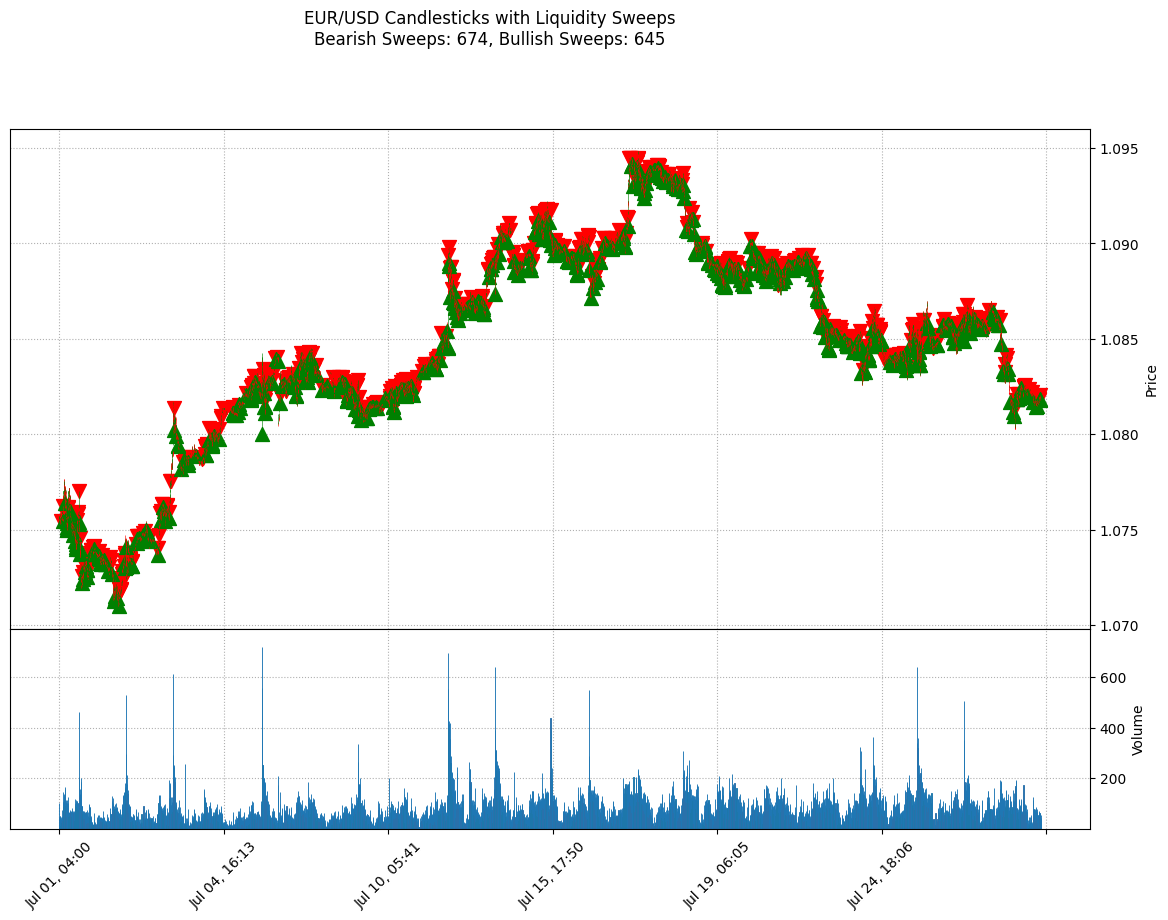


Sweep Statistics:
--------------------
No Signal (0): 28515
Bearish Sweeps (1): 674
Bullish Sweeps (2): 645

Sweep Performance Metrics:
---------------------------------------------
Bearish Sweeps: 49.1% win rate, -0.1 pips avg movement
Bullish Sweeps: 52.2% win rate, 0.3 pips avg movement


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

def plot_candlestick_sweeps(data):
    
    """
    Plot candlestick chart with improved sweep markers
    """

    data['Time'] = pd.to_datetime(data['Time'])
    data = data.set_index('Time')
    
    # Create marker data arrays
    bearish_data = pd.Series(index=data.index, data=np.nan)
    bullish_data = pd.Series(index=data.index, data=np.nan)
    
    # Fill in marker points at the start of sweep zones
    bearish_data[data['signal'] == 1] = data['High'][data['signal'] == 1]
    bullish_data[data['signal'] == 2] = data['Low'][data['signal'] == 2]
    
    # Create plot with markers
    apdict = [
        mpf.make_addplot(bearish_data, type='scatter', marker='v', 
                        markersize=100, color='red'),
        mpf.make_addplot(bullish_data, type='scatter', marker='^', 
                        markersize=100, color='green')
    ]
    
    # Style configuration
    mc = mpf.make_marketcolors(
        up='green', down='red',
        edge='inherit', wick='inherit',
        volume='in'
    )
    
    style = mpf.make_mpf_style(
        marketcolors=mc,
        gridstyle=':',
        y_on_right=True
    )
    
    # Create the figure with title showing sweep counts
    sweep_counts = data['signal'].value_counts()
    bearish_count = sweep_counts.get(1, 0)
    bullish_count = sweep_counts.get(2, 0)
    title = f'EUR/USD Candlesticks with Liquidity Sweeps\nBearish Sweeps: {bearish_count}, Bullish Sweeps: {bullish_count}'
    
    fig, axes = mpf.plot(
        data,
        type='candle',
        style=style,
        title=title,
        volume=True,
        figsize=(15, 10),
        addplot=apdict,
        returnfig=True
    )
    
    plt.tight_layout()
    return fig, axes

# Create the plot
fig, axes = plot_candlestick_sweeps(data)
plt.show()

# Print statistics
print("\nSweep Statistics:")
print("-" * 20)
sweep_counts = data['signal'].value_counts().sort_index()
print(f"No Signal (0): {sweep_counts.get(0, 0)}")
print(f"Bearish Sweeps (1): {sweep_counts.get(1, 0)}")
print(f"Bullish Sweeps (2): {sweep_counts.get(2, 0)}")

# Calculate win rate and average movement
def calculate_sweep_metrics(data, periods=5):
    """Calculate metrics for sweeps"""
    movements = {'Bearish': [], 'Bullish': []}
    wins = {'Bearish': 0, 'Bullish': 0}
    total = {'Bearish': 0, 'Bullish': 0}
    
    for i in range(len(data) - periods):
        if data['signal'].iloc[i] == 1:  # Bearish sweep
            start_price = data['Close'].iloc[i]
            end_price = data['Close'].iloc[i + periods]
            movement = (end_price - start_price) * 10000  # Convert to pips
            movements['Bearish'].append(movement)
            total['Bearish'] += 1
            if movement < 0:  # Price went down = win for bearish
                wins['Bearish'] += 1
                
        elif data['signal'].iloc[i] == 2:  # Bullish sweep
            start_price = data['Close'].iloc[i]
            end_price = data['Close'].iloc[i + periods]
            movement = (end_price - start_price) * 10000  # Convert to pips
            movements['Bullish'].append(movement)
            total['Bullish'] += 1
            if movement > 0:  # Price went up = win for bullish
                wins['Bullish'] += 1
    
    return movements, wins, total

movements, wins, total = calculate_sweep_metrics(data)

print("\nSweep Performance Metrics:")
print("-" * 45)
if total['Bearish'] > 0:
    win_rate_bearish = (wins['Bearish'] / total['Bearish']) * 100
    avg_move_bearish = np.mean(movements['Bearish'])
    print(f"Bearish Sweeps: {win_rate_bearish:.1f}% win rate, {avg_move_bearish:.1f} pips avg movement")

if total['Bullish'] > 0:
    win_rate_bullish = (wins['Bullish'] / total['Bullish']) * 100
    avg_move_bullish = np.mean(movements['Bullish'])
    print(f"Bullish Sweeps: {win_rate_bullish:.1f}% win rate, {avg_move_bullish:.1f} pips avg movement")

In [121]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def detect_sweeps_improved(df, length=5):
    """
    Enhanced sweep detector with better signal quality
    """
    signals = []
    pivot_highs = []
    pivot_lows = []
    
    for i in range(length + 1):
        signals.append(0)
    
    def is_pivot_high(window, mid_idx):
        mid_high = window.iloc[mid_idx]['High']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_high > left_section['High'].max() and 
                mid_high > right_section['High'].max())
    
    def is_pivot_low(window, mid_idx):
        mid_low = window.iloc[mid_idx]['Low']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_low < left_section['Low'].min() and 
                mid_low < right_section['Low'].min())
    
    # Calculate average volatility
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # Main detection loop
    for i in range(length + 1, len(df)):
        current_candle = df.iloc[i]
        window = df.iloc[i-length-1:i]
        mid_idx = len(window) // 2
        
        signal = 0
        
        # Update pivot points
        if is_pivot_high(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['High']
            pivot_highs.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
            
        if is_pivot_low(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['Low']
            pivot_lows.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
        
        # Enhanced sweep detection
        vol_threshold = df['Volume'].rolling(20).mean().iloc[i] * 1.2
        
        # Bearish sweeps
        for ph in pivot_highs:
            if ph['active']:
                sweep_size = current_candle['High'] - ph['price']
                if (sweep_size > 0 and
                    sweep_size < current_candle['ATR'] * 0.5 and
                    current_candle['Close'] < ph['price'] and
                    current_candle['Volume'] > vol_threshold):
                    signal = 1
                    ph['active'] = False
                elif current_candle['Close'] > ph['price']:
                    ph['active'] = False
                    
        # Bullish sweeps
        for pl in pivot_lows:
            if pl['active']:
                sweep_size = pl['price'] - current_candle['Low']
                if (sweep_size > 0 and
                    sweep_size < current_candle['ATR'] * 0.5 and
                    current_candle['Close'] > pl['price'] and
                    current_candle['Volume'] > vol_threshold):
                    signal = 2
                    pl['active'] = False
                elif current_candle['Close'] < pl['price']:
                    pl['active'] = False
        
        signals.append(signal)
        
        # Clean up old pivot points
        pivot_highs = [ph for ph in pivot_highs if i - ph['index'] <= 100]
        pivot_lows = [pl for pl in pivot_lows if i - pl['index'] <= 100]
    
    return signals

def run_backtest(data, initial_balance=100000, risk_percent=0.5, reward_percent=1.5, max_bars=3):
    """
    Enhanced backtest with original output format
    """
    balance = initial_balance
    trades = []
    active_trade = None
    
    # Ensure data has proper datetime index
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])
    data.set_index('Time', inplace=True)
    
    # Add trend filter
    data['EMA20'] = data['Close'].ewm(span=20).mean()
    
    for i in range(len(data)):
        current_bar = data.iloc[i]
        current_time = data.index[i]
        
        # Handle existing trade first
        if active_trade is not None:
            active_trade['bars_held'] += 1
            
            # Check stop loss
            if (active_trade['direction'] == 'long' and current_bar['Low'] <= active_trade['stop_loss']) or \
               (active_trade['direction'] == 'short' and current_bar['High'] >= active_trade['stop_loss']):
                profit = active_trade['position_size'] * (active_trade['stop_loss'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = active_trade['stop_loss']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'stop_loss'
                trades.append(active_trade)
                balance += profit
                active_trade = None
                
            # Check take profit
            elif (active_trade['direction'] == 'long' and current_bar['High'] >= active_trade['take_profit']) or \
                 (active_trade['direction'] == 'short' and current_bar['Low'] <= active_trade['take_profit']):
                profit = active_trade['position_size'] * (active_trade['take_profit'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = active_trade['take_profit']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'take_profit'
                trades.append(active_trade)
                balance += profit
                active_trade = None
                
            # Check max bars
            elif active_trade['bars_held'] >= max_bars:
                profit = active_trade['position_size'] * (current_bar['Close'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = current_bar['Close']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'max_bars'
                trades.append(active_trade)
                balance += profit
                active_trade = None
        
        # Check for new trade if no active trade
        if active_trade is None and i > 20:  # Wait for EMA to warm up
            if current_bar['signal'] == 2:  # Bullish sweep
                # Only trade if price is near EMA
                if abs(current_bar['Close'] - current_bar['EMA20']) / current_bar['Close'] < 0.0005:
                    entry_price = current_bar['Close']
                    stop_loss = current_bar['Low'] - (current_bar['High'] - current_bar['Low']) * 0.1
                    pip_risk = abs(entry_price - stop_loss)
                    position_size = (balance * risk_percent / 100) / pip_risk
                    take_profit = entry_price + pip_risk * (reward_percent / risk_percent)
                    
                    active_trade = {
                        'entry_time': current_time,
                        'direction': 'long',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'position_size': position_size,
                        'bars_held': 0
                    }
                    
            elif current_bar['signal'] == 1:  # Bearish sweep
                # Only trade if price is near EMA
                if abs(current_bar['Close'] - current_bar['EMA20']) / current_bar['Close'] < 0.0005:
                    entry_price = current_bar['Close']
                    stop_loss = current_bar['High'] + (current_bar['High'] - current_bar['Low']) * 0.1
                    pip_risk = abs(stop_loss - entry_price)
                    position_size = (balance * risk_percent / 100) / pip_risk
                    take_profit = entry_price - pip_risk * (reward_percent / risk_percent)
                    
                    active_trade = {
                        'entry_time': current_time,
                        'direction': 'short',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'position_size': position_size,
                        'bars_held': 0
                    }
    
    # Print detailed trade information
    print("\nDetailed Trade History:")
    print("-" * 120)
    print(f"{'Entry Time':<25} {'Exit Time':<25} {'Direction':<8} {'Entry':<10} {'Exit':<10} {'P/L':<10} {'Exit Reason':<12}")
    print("-" * 120)
    
    total_profit = 0
    winning_trades = 0
    for trade in trades:
        entry_time = trade['entry_time'].strftime('%Y-%m-%d %H:%M')
        exit_time = trade['exit_time'].strftime('%Y-%m-%d %H:%M')
        print(f"{entry_time:<25} {exit_time:<25} {trade['direction']:<8} "
              f"{trade['entry_price']:<10.5f} {trade['exit_price']:<10.5f} "
              f"{trade['profit']:<10.2f} {trade['exit_reason']:<12}")
        total_profit += trade['profit']
        if trade['profit'] > 0:
            winning_trades += 1
    
    # Print summary statistics
    win_rate = (winning_trades / len(trades) * 100) if trades else 0
    print("\nBacktest Summary:")
    print("-" * 50)
    print(f"Total Trades: {len(trades)}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance: ${balance:,.2f}")
    print(f"Total Profit: ${total_profit:,.2f}")
    print(f"Return: {((balance - initial_balance) / initial_balance * 100):.2f}%")
    
    return trades, balance

In [136]:
# Usage:
def run_strategy(data):
    """
    Run the complete strategy with the improved sweep detector
    """
    # Add sweep signals
    data['signal'] = detect_sweeps_improved(data, length=5)
    
    # Run backtest
    trades, final_balance = run_backtest(
        data,
        initial_balance=100000,
        risk_percent=1.7,
        reward_percent=4.5,
        max_bars=70
    )
    
    return trades, final_balance


run_strategy(data)


Detailed Trade History:
------------------------------------------------------------------------------------------------------------------------
Entry Time                Exit Time                 Direction Entry      Exit       P/L        Exit Reason 
------------------------------------------------------------------------------------------------------------------------
2024-03-20 05:57          2024-03-20 05:59          long     1.08664    1.08659    -1700.00   stop_loss   
2024-03-20 06:18          2024-03-20 06:20          short    1.08685    1.08689    -1671.10   stop_loss   
2024-03-20 06:52          2024-03-20 06:57          short    1.08686    1.08693    -1642.69   stop_loss   
2024-03-20 10:08          2024-03-20 10:11          long     1.08370    1.08390    4274.38    take_profit 
2024-03-20 11:05          2024-03-20 11:20          short    1.08420    1.08382    4466.73    take_profit 
2024-03-20 12:36          2024-03-20 12:38          long     1.08410    1.08407    -1763.3

([{'entry_time': Timestamp('2024-03-20 05:57:00+0000', tz='UTC'),
   'direction': 'long',
   'entry_price': 1.08664,
   'stop_loss': 1.086592,
   'take_profit': 1.0867670588235296,
   'position_size': 35416666.666631244,
   'bars_held': 2,
   'exit_price': 1.086592,
   'exit_time': Timestamp('2024-03-20 05:59:00+0000', tz='UTC'),
   'profit': -1699.9999999999998,
   'exit_reason': 'stop_loss'},
  {'entry_time': Timestamp('2024-03-20 06:18:00+0000', tz='UTC'),
   'direction': 'short',
   'entry_price': 1.08685,
   'stop_loss': 1.0868939999999998,
   'take_profit': 1.0867335294117655,
   'position_size': 37979545.454794966,
   'bars_held': 2,
   'exit_price': 1.0868939999999998,
   'exit_time': Timestamp('2024-03-20 06:20:00+0000', tz='UTC'),
   'profit': -1671.1,
   'exit_reason': 'stop_loss'},
  {'entry_time': Timestamp('2024-03-20 06:52:00+0000', tz='UTC'),
   'direction': 'short',
   'entry_price': 1.08686,
   'stop_loss': 1.0869270000000002,
   'take_profit': 1.0866826470588227,
   